## Predicting Web Traficc - Time Series

Traffic forecast for an ecommerce website with model machine learning XGBoost

In [64]:
# Imports
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [38]:
import seaborn as sns

In [2]:
# Dataset
df = pd.read_csv('dataset\dataset_webtraffic.csv')


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_14876\4293588047.py:2: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('dataset\dataset_webtraffic.csv')


In [3]:
df.head()

dia_semana  eh_feriado  campanha_marketing_ativa  taxa_media_conversao  \
0           4           1                         1             14.594054   
1           6           0                         1             46.623849   
2           6           0                         1             37.389981   
3           6           0                         1             27.957446   
4           6           1                         0             11.980802   

   num_visitas_dia_anterior  num_visitas  
0                        89          104  
1                        94          128  
2                        96          133  
3                       101          112  
4                       105          120

#### Analise Explorat√≥ria:

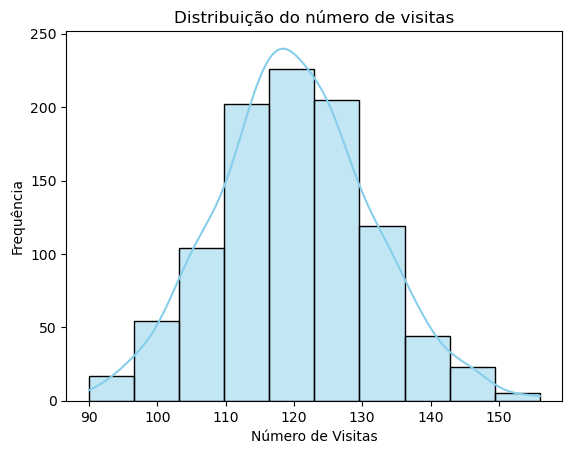

In [41]:
# Distribuicao do numero de visitas
sns.histplot(df['num_visitas'], bins=10, kde=True, color='skyblue')
plt.title('Distribui√ß√£o do n√∫mero de visitas')
plt.xlabel('N√∫mero de Visitas')
plt.ylabel('Frequ√™ncia')
plt.show()

**Distribuicao do numero de visitas**

Descri√ß√£o: Histograma levemente sim√©trico, indicando que o n√∫mero de visitas di√°rias segue aproximadamente uma distribui√ß√£o normal, centrada entre 115 e 125 visitas.

Insight: N√£o h√° evid√™ncia forte de assimetria ou de outliers extremos. A maioria dos valores est√° concentrada em torno da m√©dia, o que sugere estabilidade no volume di√°rio de visitas.

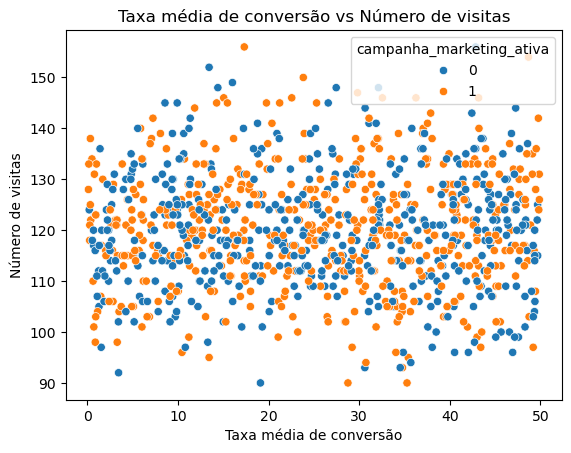

In [ ]:
# Rela√ß√£o entre taxa m√©dia de convers√£o e visitas
sns.scatterplot(x='taxa_media_conversao', y='num_visitas', data=df, hue='campanha_marketing_ativa')
plt.title('Taxa m√©dia de convers√£o vs N√∫mero de visitas')
plt.xlabel('Taxa m√©dia de convers√£o')
plt.ylabel('N√∫mero de visitas')
plt.show()


**Rela√ß√£o entre taxa m√©dia de convers√£o e visitas**

Descri√ß√£o: Um scatter plot colorido por campanha_marketing_ativa.

Insight: N√£o h√° uma tend√™ncia clara entre a taxa m√©dia de convers√£o e o n√∫mero de visitas. Os pontos est√£o bem dispersos, indicando pouca correla√ß√£o direta. Tamb√©m n√£o se observa diferen√ßa vis√≠vel nas cores (campanhas ativas ou n√£o) impactando drasticamente o padr√£o.


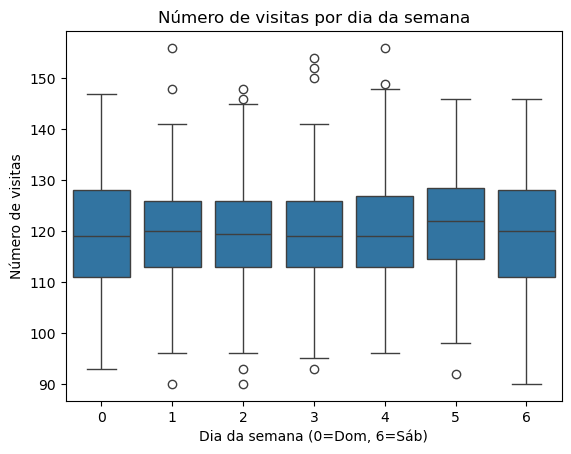

In [43]:
# Efeito do dia da semana
sns.boxplot(x='dia_semana', y='num_visitas', data=df)
plt.title('N√∫mero de visitas por dia da semana')
plt.xlabel('Dia da semana (0=Dom, 6=S√°b)')
plt.ylabel('N√∫mero de visitas')
plt.show()

**Efeito do dia da semana**

Descri√ß√£o: Boxplots mostrando distribui√ß√£o das visitas em cada dia (0=Domingo, 6=S√°bado).

Insight: N√£o parece haver grandes varia√ß√µes entre os dias da semana. As medianas s√£o pr√≥ximas, indicando que o tr√°fego √© relativamente constante ao longo da semana. H√° alguns outliers em todos os dias.

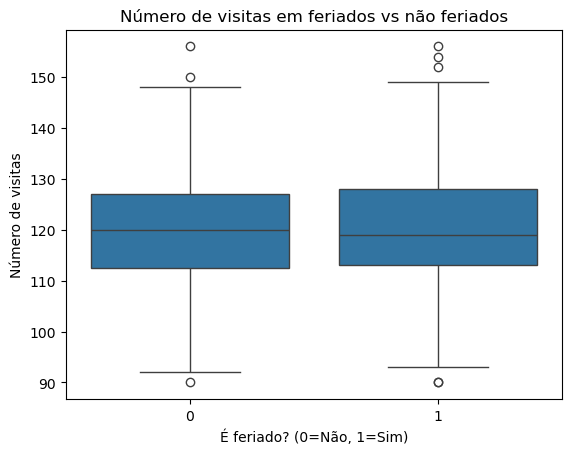

In [44]:
# Visitas em feriados vs n√£o feriados
sns.boxplot(x='eh_feriado', y='num_visitas', data=df)
plt.title('N√∫mero de visitas em feriados vs n√£o feriados')
plt.xlabel('√â feriado? (0=N√£o, 1=Sim)')
plt.ylabel('N√∫mero de visitas')
plt.show()

**Visitas em feriados vs n√£o feriados**

Descri√ß√£o: Boxplots comparando visitas em feriados (1) e n√£o feriados (0).

Insight: As distribui√ß√µes s√£o muito semelhantes, o que indica que feriados n√£o t√™m um impacto vis√≠vel no n√∫mero de visitas. As medianas s√£o praticamente iguais, com amplitude semelhante.

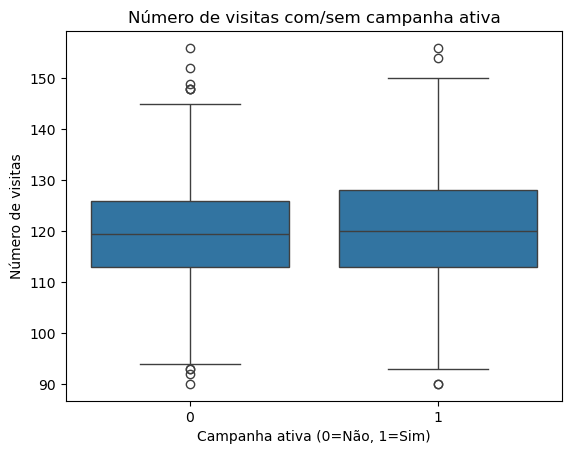

In [45]:
#Efeito da campanha de marketing ativa
sns.boxplot(x='campanha_marketing_ativa', y='num_visitas', data=df)
plt.title('N√∫mero de visitas com/sem campanha ativa')
plt.xlabel('Campanha ativa (0=N√£o, 1=Sim)')
plt.ylabel('N√∫mero de visitas')
plt.show()

**Efeito da campanha de marketing ativa**

Descri√ß√£o: Boxplots para dias com e sem campanhas ativas.

Insight: As distribui√ß√µes s√£o tamb√©m muito parecidas. Isso sugere que a vari√°vel campanha_marketing_ativa por si s√≥ n√£o est√° relacionada diretamente a um aumento claro no volume de visitas.


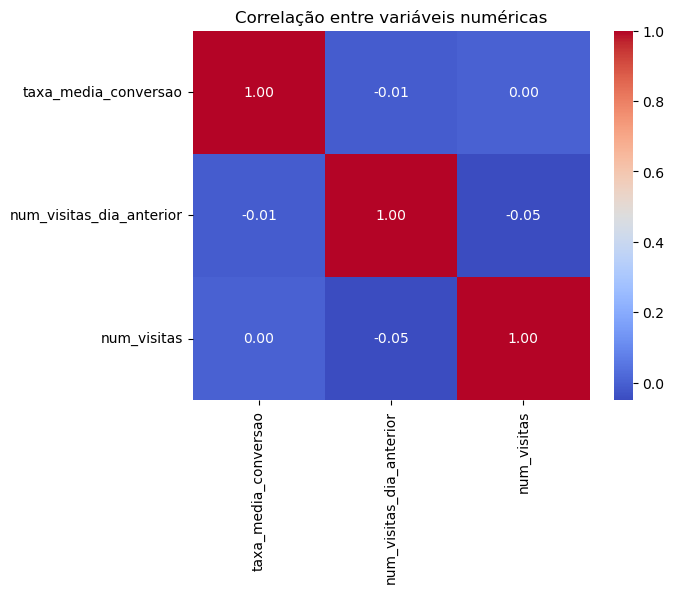

In [46]:
# Correla√ß√£o entre vari√°veis num√©ricas
corr = df[['taxa_media_conversao','num_visitas_dia_anterior','num_visitas']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correla√ß√£o entre vari√°veis num√©ricas')
plt.show()

**Correla√ß√£o entre vari√°veis num√©ricas:**

**Descri√ß√£o**: Um heatmap das correla√ß√µes entre taxa_media_conversao, num_visitas_dia_anterior e num_visitas.

**Insight**: As correla√ß√µes s√£o muito fracas (praticamente zero), sugerindo que dentro do intervalo analisado, nenhuma dessas vari√°veis explica diretamente o comportamento das outras.

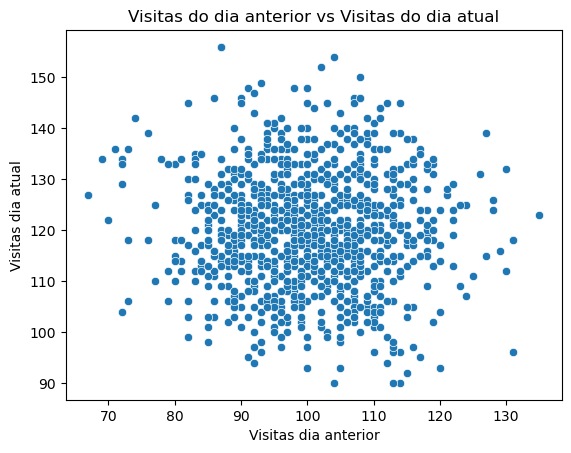

In [47]:
# Rela√ß√£o entre visitas do dia anterior e o dia atual
sns.scatterplot(x='num_visitas_dia_anterior', y='num_visitas', data=df)
plt.title('Visitas do dia anterior vs Visitas do dia atual')
plt.xlabel('Visitas dia anterior')
plt.ylabel('Visitas dia atual')
plt.show()

**Rela√ß√£o entre visitas do dia anterior e o dia atual**

Descri√ß√£o: Um scatter plot entre visitas do dia anterior e visitas do dia atual.

Insight: N√£o existe um padr√£o claro nem uma correla√ß√£o linear entre o tr√°fego de um dia e o dia seguinte. O n√∫mero de visitas varia independentemente do valor do dia anterior.

**Conclus√£o geral**

A an√°lise explorat√≥ria mostra um volume de visitas relativamente est√°vel, sem grandes varia√ß√µes por dia da semana, feriados ou campanhas.

N√£o h√° ind√≠cios de autocorrela√ß√£o (visitas de um dia n√£o predizem claramente o pr√≥ximo) nem correla√ß√µes fortes com taxa de convers√£o.

Isso indica que o tr√°fego pode depender de outros fatores n√£o capturados no dataset, ou requer uma modelagem mais complexa (ex: vari√°veis sazonais, externas, ou dados hist√≥ricos mais longos).

Por√©m para modelagem preditiva, indica fortemente uma s√©rie estacion√°ria.

#### Teste de Estacionariedade e Estat√≠sticas M√≥veis

In [56]:
# Fun√ß√£o para testar a estacionaridade (Dickey Fullher)
def testa_estacionaridade(serie, window = 12, title = 'Estat√≠sticas M√≥veis e Teste Dickey-Fuller'):
    """
    Fun√ß√£o para testar a estacionaridade de uma s√©rie temporal.
    
    Par√¢metros:
    - serie: pandas.Series. S√©rie temporal a ser testada.
    - window: int. Janela para c√°lculo das estat√≠sticas m√≥veis.
    - title: str. T√≠tulo para os gr√°ficos.
    """
    # Calcula estat√≠sticas m√≥veis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estat√≠sticas m√≥veis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'M√©dia M√≥vel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padr√£o M√≥vel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estat√≠stica do Teste', 
                                               'Valor-p', 
                                               'N√∫mero de Lags Consideradas', 
                                               'N√∫mero de Observa√ß√µes Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Cr√≠tico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclus√£o baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclus√£o:\nO valor-p √© maior que 0.05 e, portanto, n√£o temos evid√™ncias para rejeitar a hip√≥tese nula.\nEssa s√©rie provavelmente n√£o √© estacion√°ria.')
    else:
        print('\nConclus√£o:\nO valor-p √© menor que 0.05 e, portanto,temos evid√™ncias para rejeitar a hip√≥tese nula.\nEssa s√©rie provavelmente √© estacion√°ria.')

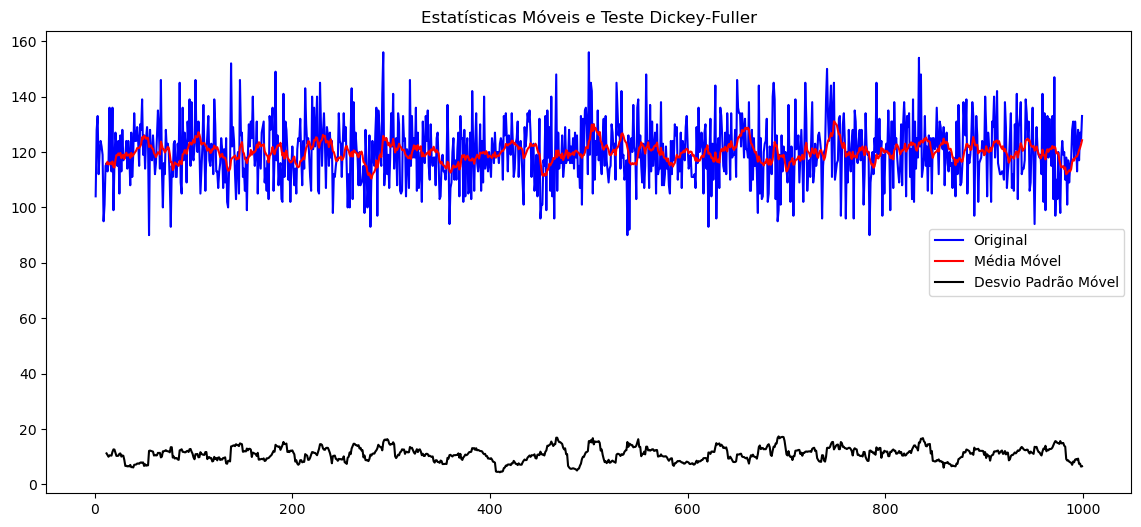


Resultado do Teste Dickey-Fuller:
Estat√≠stica do Teste            -21.911253
Valor-p                           0.000000
N√∫mero de Lags Consideradas       1.000000
N√∫mero de Observa√ß√µes Usadas    997.000000
Valor Cr√≠tico (1%)               -3.436926
Valor Cr√≠tico (5%)               -2.864443
Valor Cr√≠tico (10%)              -2.568316
dtype: float64

Conclus√£o:
O valor-p √© menor que 0.05 e, portanto,temos evid√™ncias para rejeitar a hip√≥tese nula.
Essa s√©rie provavelmente √© estacion√°ria.


In [53]:
testa_estacionaridade(df['lag_num_visitas'])

#### Engenharia de Atributos:

In [ ]:
# Cria a lag de 'num_visitas' (defasagem)
df['lag_num_visitas'] = df['num_visitas'].shift(1)

In [5]:
# Remove as primeiras linhas que cont√™m NaN devido √† lag
df = df.dropna()

In [6]:
df.head()

dia_semana  eh_feriado  campanha_marketing_ativa  taxa_media_conversao  \
1           6           0                         1             46.623849   
2           6           0                         1             37.389981   
3           6           0                         1             27.957446   
4           6           1                         0             11.980802   
5           6           0                         0             35.641700   

   num_visitas_dia_anterior  num_visitas  lag_num_visitas  
1                        94          128            104.0  
2                        96          133            128.0  
3                       101          112            133.0  
4                       105          120            112.0  
5                       128          124            120.0

In [7]:
# Atualiza a lista de features para incluir a lag de 'num_visitas'
features = ['dia_semana', 'eh_feriado', 'campanha_marketing_ativa', 'taxa_media_conversao', 'num_visitas_dia_anterior', 'lag_num_visitas']

In [8]:
target = ['num_visitas']

#### Pre-processamento:

In [9]:

preprocessor = ColumnTransformer(
    transformers=[
        ('features', 'passthrough', features)  # Apenas une as colunas
    ]
)

X = preprocessor.fit_transform(df)

Divis√£o de Dados em Treinamento e Teste

In [10]:
X = df[features]

y = df[target]

In [11]:
# Divide os dados em treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Modelagem Preditiva com XGBoost

In [12]:
# Cria o modelo XGBoost
xgb_model = XGBRegressor(objective = 'reg:squarederror')

In [13]:
# Treina o modelo
xgb_model.fit(X_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Faz as previs√µes
previsoes = xgb_model.predict(X_teste)

In [57]:
previsoes

array([121.56828 , 119.4158  , 114.197556, 119.079575, 111.90411 ,
       115.30165 , 107.23249 , 120.10513 , 114.68321 , 118.16517 ,
       120.04485 , 124.16654 , 115.1554  , 132.85284 , 123.03357 ,
       118.73752 , 117.76658 , 135.48318 , 109.54117 , 125.318054,
       107.54579 , 122.89534 , 118.27399 , 124.66096 , 118.90031 ,
       127.85875 , 119.79697 , 119.59922 , 123.676476, 124.520485,
       115.15982 , 125.51853 , 103.227806, 111.63005 , 117.78882 ,
       120.50815 , 120.7389  , 121.986626, 129.79366 , 120.26763 ,
       107.25485 , 128.64627 , 125.082886, 110.30442 , 123.30251 ,
       111.780266, 111.682594, 119.049545, 107.862   , 123.91236 ,
       117.65969 , 116.78058 , 123.759995, 123.371506, 117.94355 ,
       110.56419 , 123.13875 , 117.52384 , 133.13857 , 112.360794,
       127.106606, 116.10531 , 109.883354, 134.60054 , 112.41183 ,
       108.846306, 128.35973 , 123.83191 , 111.98256 , 129.96411 ,
       119.98261 , 117.16747 , 131.43124 , 109.85963 , 114.033

#### Linha real vs previsto
Plotar lado a lado as s√©ries para comparar: Mostra como as previs√µes acompanham (ou n√£o) a s√©rie.

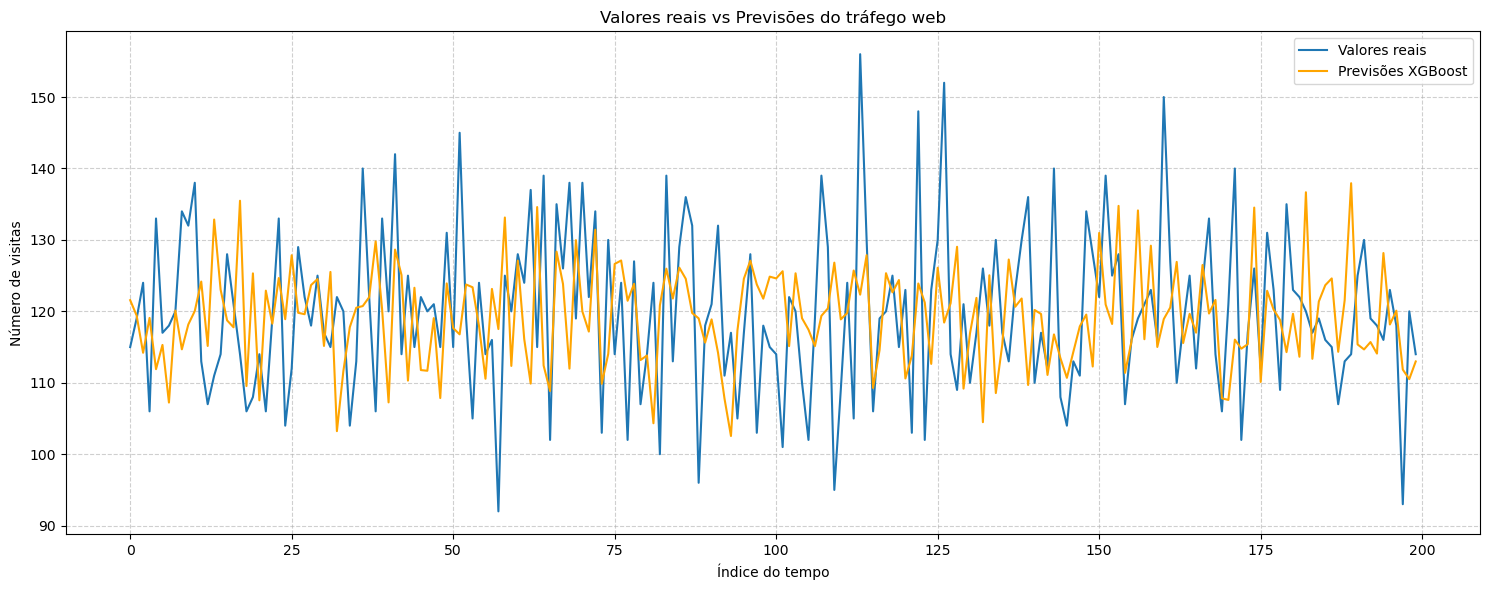

In [62]:
# Plot
plt.figure(figsize = (15, 6))
plt.plot(y_teste.values, label = 'Valores reais') 
plt.plot(previsoes, color = 'orange', label = 'Previs√µes XGBoost') 
plt.title('Valores reais vs Previs√µes do tr√°fego web')
plt.xlabel('√çndice do tempo')
plt.ylabel('N√∫mero de visitas')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(loc = 'best') 
plt.show()

####  Scatter plot previsto vs real
Para ver a qualidade do ajuste (se previs√µes se alinham √† reta y=x): Ideal para checar se o modelo sub ou superestima.

In [67]:
print(type(y_teste), y_teste.shape)
print(type(previsoes), previsoes.shape)

<class 'pandas.core.frame.DataFrame'> (200, 1)
<class 'numpy.ndarray'> (200,)


In [68]:
y_teste = y_teste.squeeze()  # transforma DataFrame (1 coluna) em Series

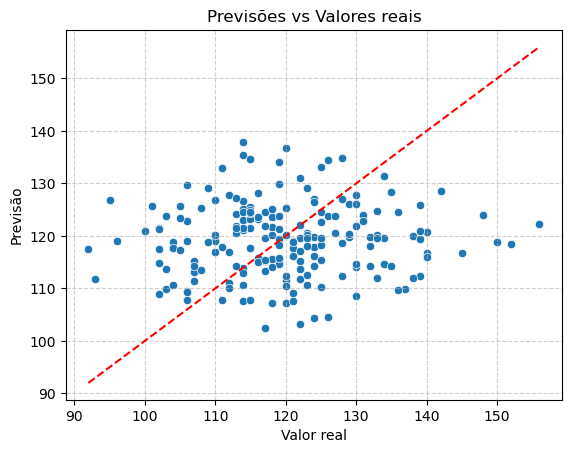

In [69]:
sns.scatterplot(x=y_teste, y=previsoes)
plt.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], 'r--')
plt.title('Previs√µes vs Valores reais')
plt.xlabel('Valor real')
plt.ylabel('Previs√£o')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Erro residual
Plotar o erro (real - previsto) ao longo do tempo, para ver se h√° vi√©s ou padr√µes: se houver padr√£o √© ruim, o modelo n√£o est√° bem ajustado, caso contr√°rio o modelo aprendeu bem.

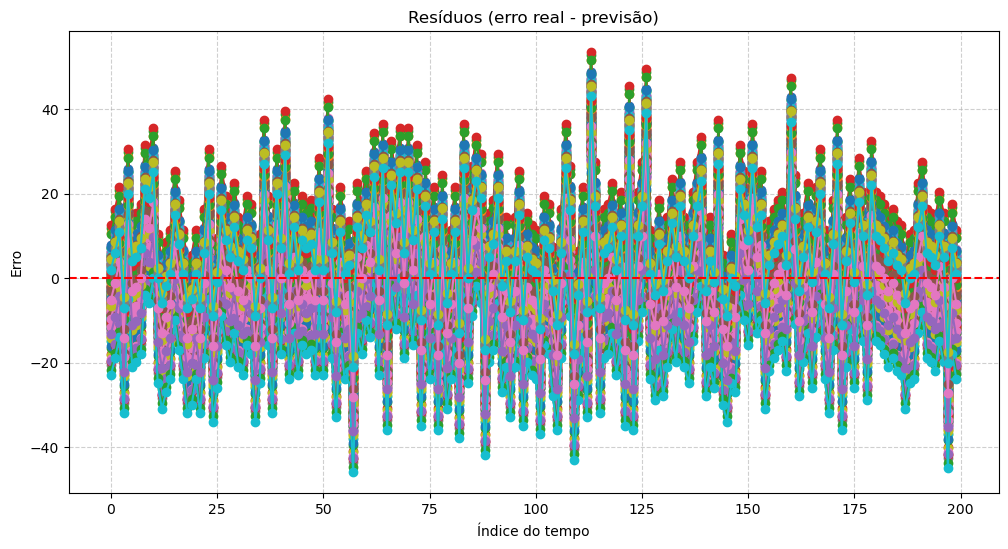

In [66]:
erros = y_teste.values - previsoes

plt.figure(figsize=(12,6))
plt.plot(erros, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title('Res√≠duos (erro real - previs√£o)')
plt.xlabel('√çndice do tempo')
plt.ylabel('Erro')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#### Avalia√ß√£o do Modelo

In [15]:
# Avalia o modelo
mse = mean_squared_error(y_teste, previsoes)
rmse = np.sqrt(mse)

In [16]:
# Exibe o RMSE
print(f'RMSE do Modelo: {rmse}')

RMSE do Modelo: 12.941345233920575


**An√°lise das previs√µes do XGBoost | RMSE**

‚úÖ Gr√°fico 1: valores reais vs previstos (linha)<br>
‚úÖ Gr√°fico 2: previs√£o vs real (scatter, linha y=x)<br>
‚úÖ Gr√°fico 3: res√≠duos ao longo do tempo<br>
‚úÖ Gr√°fico 4: histograma + KDE dos res√≠duos

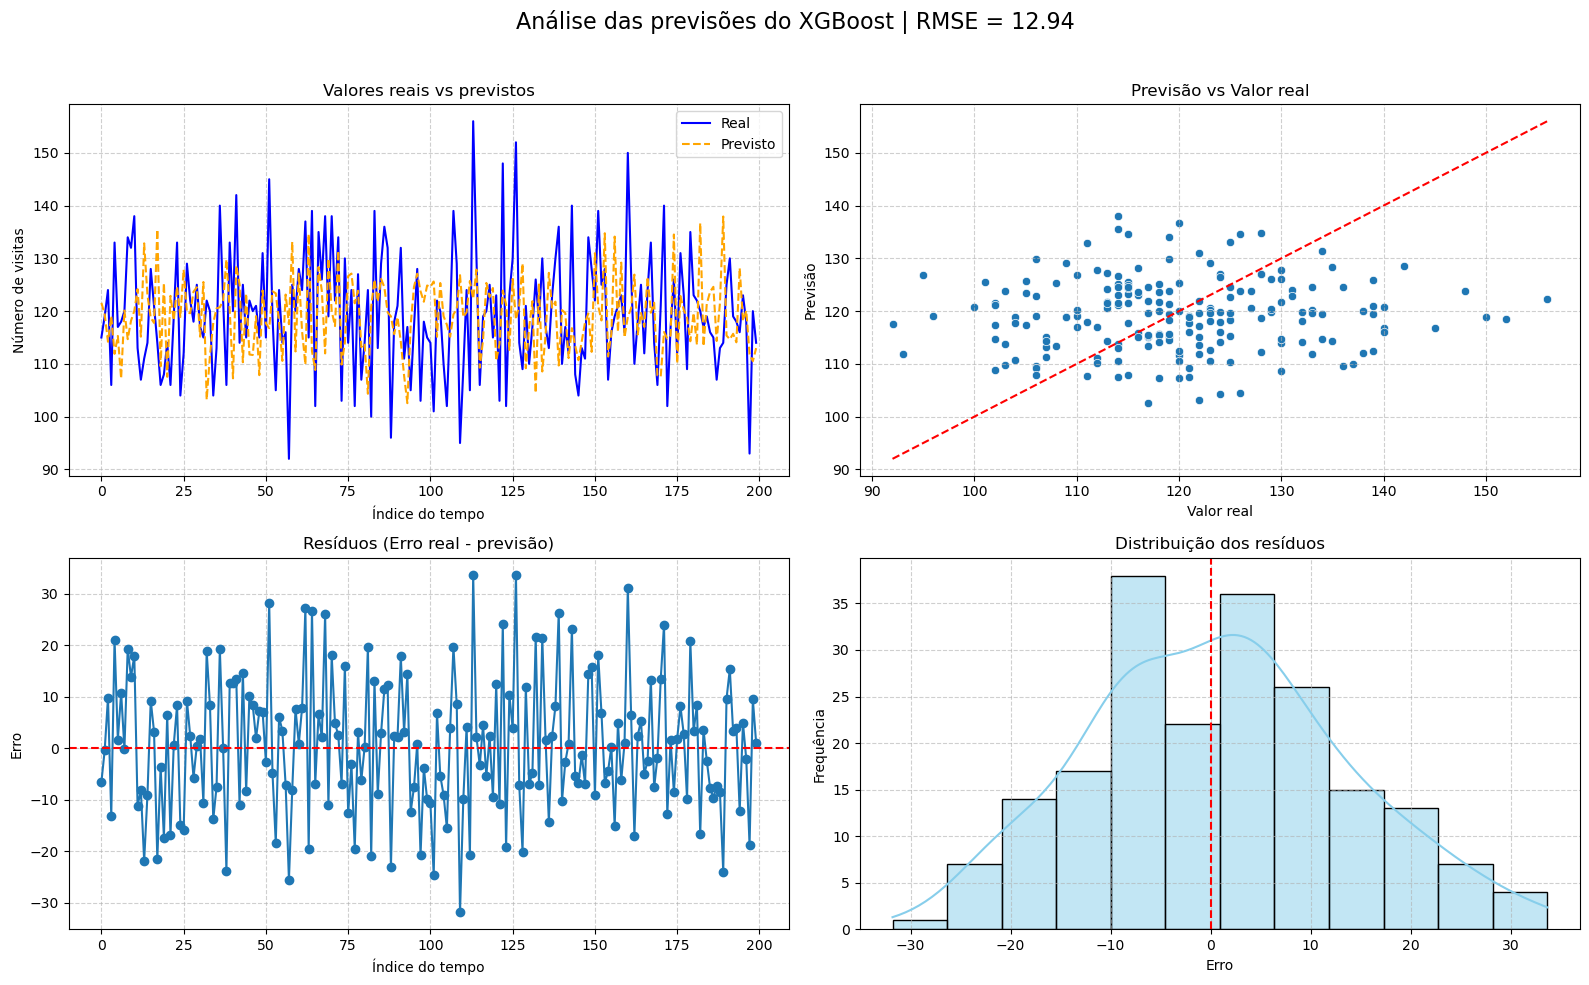

In [ ]:
# Plot RMSE Geral:

# garantir arrays corretos
y_real = np.array(y_teste).flatten()
y_pred = np.array(previsoes).flatten()
erros = y_real - y_pred

# calcular novamente para garantir
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)

# criar a figura
plt.figure(figsize=(16,10))
plt.suptitle(f'An√°lise das previs√µes do XGBoost | RMSE = {rmse:.2f}', fontsize=16)

# ------------------------------
# 1. Linha real vs previsto
plt.subplot(2,2,1)
plt.plot(y_real, label='Real', color='blue')
plt.plot(y_pred, label='Previsto', color='orange', linestyle='--')
plt.title('Valores reais vs previstos')
plt.xlabel('√çndice do tempo')
plt.ylabel('N√∫mero de visitas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# 2. Scatter previs√£o vs real
plt.subplot(2,2,2)
sns.scatterplot(x=y_real, y=y_pred)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
plt.title('Previs√£o vs Valor real')
plt.xlabel('Valor real')
plt.ylabel('Previs√£o')
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# 3. Res√≠duos no tempo
plt.subplot(2,2,3)
plt.plot(erros, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.title('Res√≠duos (Erro real - previs√£o)')
plt.xlabel('√çndice do tempo')
plt.ylabel('Erro')
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# 4. Distribui√ß√£o dos res√≠duos
plt.subplot(2,2,4)
sns.histplot(erros, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribui√ß√£o dos res√≠duos')
plt.xlabel('Erro')
plt.ylabel('Frequ√™ncia')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


üìù **Conclus√£o sobre o desempenho do modelo**

O modelo XGBoost desenvolvido para previs√£o do tr√°fego web apresentou um RMSE ‚âà 12.94, indicando que, em m√©dia, suas previs√µes diferem dos valores reais em aproximadamente 13 visitas di√°rias. Dado que o volume t√≠pico de visitas gira em torno de 120 visitas por dia, o erro representa cerca de 10%, o que pode ser considerado um desempenho razo√°vel para aplica√ß√µes operacionais que tolerem pequenas flutua√ß√µes.

A an√°lise visual refor√ßa esses achados:

* O gr√°fico temporal mostra que o modelo consegue acompanhar a tend√™ncia geral da s√©rie, embora apresente varia√ß√µes pontuais.

* O scatter plot evidencia que a maioria das previs√µes se aproxima da linha ideal (y=x), mas com certa dispers√£o, explicando o RMSE.

* O gr√°fico de res√≠duos ao longo do tempo indica que os erros n√£o seguem um padr√£o claro, o que √© positivo para descartar vi√©s sistem√°tico.

* Por fim, o histograma dos res√≠duos mostra uma distribui√ß√£o aproximadamente centrada em zero, embora com caudas que justificam o n√≠vel do erro m√©dio quadr√°tico encontrado.

Dessa forma, o modelo √© capaz de capturar o comportamento do tr√°fego com um n√≠vel de erro que pode ser considerado adequado para previs√µes de curto prazo, mas abre espa√ßo para melhorias, como inclus√£o de novas vari√°veis explicativas ou testes com abordagens h√≠bridas (ex.: XGBoost + vari√°veis sazonais ou lags adicionais).


#### Salva Modelo em formato Pkl

In [17]:
# Salva o modelo treinado em disco
joblib.dump(xgb_model, 'modelo_projeto_webtraffic.pkl')

['modelo_projeto_webtraffic.pkl']

#### Aplica√ß√£o a novos Dados

In [18]:
import time  # Importar o m√≥dulo time para usar sleep
from realtime_data_generate import gera_dados_tempo_real

In [19]:
# Definir as features (incluindo a lag)
features = ['dia_semana', 'eh_feriado', 'campanha_marketing_ativa', 'taxa_media_conversao', 'num_visitas_dia_anterior', 'lag_num_visitas']

In [20]:
# Carregar o modelo salvo
xgb_model = joblib.load('modelo_projeto_webtraffic.pkl')

In [21]:
# Vari√°vel para armazenar a lag (tem que ser zero para a primeira previs√£o)
var_lag_num_visitas = 0  

In [22]:
# Fun√ß√£o para gerar dados em tempo real e calcular a lag
def gerar_dados_realtime_com_lag(var_lag_num_visitas):
    
    # Gerar novos dados em tempo real
    real_time_data = gera_dados_tempo_real()

    # Adicionar a vari√°vel de lag (visitas do dia anterior)
    real_time_data['lag_num_visitas'] = var_lag_num_visitas

    return real_time_data

In [23]:
# Inicializar uma lista para armazenar as previs√µes
todas_previsoes = []

In [24]:
# Loop para gerar 7 previs√µes consecutivas
for i in range(7):

    # Gerar novos dados com lag
    real_time_data = gerar_dados_realtime_com_lag(var_lag_num_visitas)

    # Verificar se h√° dados para processar
    if not real_time_data.empty:
        
        # Preparar os dados para a previs√£o
        real_time_features = real_time_data[features]

        # Fazer a previs√£o
        predictions = xgb_model.predict(real_time_features)

        # Armazenar a previs√£o e as features utilizadas
        real_time_data['num_previsto_visitas'] = predictions.astype(int)
        todas_previsoes.append(real_time_data.copy())

        # Exibir os dados e a previs√£o atual
        print(f'\nPrevis√£o {i+1}:')
        print(f'Novos Dados de Entrada: {real_time_data[features].iloc[0].tolist()}')
        print(f'Previs√£o de Visitas: {real_time_data["num_previsto_visitas"].iloc[0]}\n')

        # Atualizar a lag para a pr√≥xima previs√£o
        var_lag_num_visitas = int(real_time_data['num_previsto_visitas'].iloc[0])

        # Pausar por 2 segundos antes da pr√≥xima previs√£o
        time.sleep(2)

# Ap√≥s o loop, todas as previs√µes est√£o armazenadas na lista 'todas_previsoes'.


Previs√£o 1:
Novos Dados de Entrada: [1.0, 1.0, 0.0, 14.539469244616615, 99.0, 0.0]
Previs√£o de Visitas: 110


Previs√£o 2:
Novos Dados de Entrada: [4.0, 1.0, 1.0, 35.73476259499174, 104.0, 110.0]
Previs√£o de Visitas: 119


Previs√£o 3:
Novos Dados de Entrada: [5.0, 0.0, 0.0, 21.335737777334845, 115.0, 119.0]
Previs√£o de Visitas: 121


Previs√£o 4:
Novos Dados de Entrada: [3.0, 0.0, 0.0, 35.17697552499398, 99.0, 121.0]
Previs√£o de Visitas: 122


Previs√£o 5:
Novos Dados de Entrada: [1.0, 0.0, 0.0, 10.89201477468959, 101.0, 122.0]
Previs√£o de Visitas: 130


Previs√£o 6:
Novos Dados de Entrada: [0.0, 1.0, 1.0, 23.71038680367179, 109.0, 130.0]
Previs√£o de Visitas: 128


Previs√£o 7:
Novos Dados de Entrada: [2.0, 0.0, 0.0, 23.428166039009014, 112.0, 128.0]
Previs√£o de Visitas: 114



In [39]:
# ‚úÖ Concatenar todas as previs√µes e salvar em CSV
df_previsoes = pd.concat(todas_previsoes, ignore_index=True)
df_previsoes.to_csv("previsoes.csv", index=False)

print("Arquivo previsoes.csv salvo com sucesso.")

Arquivo previsoes.csv salvo com sucesso.


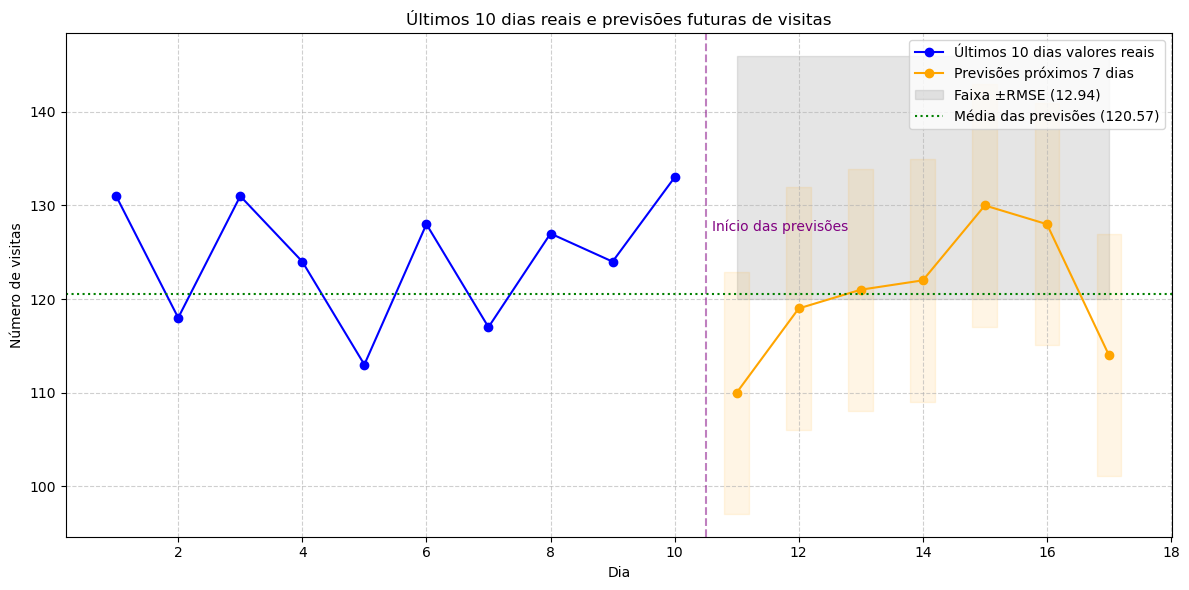

In [89]:
# extrair as previs√µes salvas no loop
prevs = [df['num_previsto_visitas'].iloc[0] for df in todas_previsoes]

# pegar os √∫ltimos 10 dias reais
valores_reais = df['lag_num_visitas'].tail(10).values
dias_reais = range(1, 11)

# √∫ltimo valor real (usado para faixa de confian√ßa)
ultimo_real = valores_reais[-1]

# limites superior e inferior com base no RMSE
limite_sup = [ultimo_real + rmse] * 7
limite_inf = [ultimo_real - rmse] * 7

# dias de previs√£o ap√≥s os reais
dias_previsao = range(11, 18)

plt.figure(figsize=(12, 6))

# plot √∫ltimos 10 valores reais
plt.plot(dias_reais, valores_reais, color='blue', linestyle='-', marker='o', label='√öltimos 10 dias valores reais')

plt.axvline(x=10.5, color='purple', linestyle='--', alpha=0.5)
plt.text(10.6, plt.ylim()[1]*0.95, 'In√≠cio das previs√µes', color='purple')

# plot previs√µes
plt.plot(dias_previsao, prevs, marker='o', color='orange', label='Previs√µes pr√≥ximos 7 dias')

# faixa de confian√ßa ¬±RMSE
plt.fill_between(dias_previsao, limite_inf, limite_sup, color='gray', alpha=0.2,
                 label=f'Faixa ¬±RMSE ({rmse:.2f})')

# m√©dia das previs√µes
media_prevs = np.mean(prevs)
plt.axhline(media_prevs, color='green', linestyle=':', label=f'M√©dia das previs√µes ({media_prevs:.2f})')

# faixa individual para cada previs√£o
for i, valor in enumerate(prevs):
    plt.fill_between(
        [dias_previsao[i] - 0.2, dias_previsao[i] + 0.2],
        [valor - rmse, valor - rmse],
        [valor + rmse, valor + rmse],
        color='orange',
        alpha=0.1
    )

plt.title('√öltimos 10 dias reais e previs√µes futuras de visitas')
plt.xlabel('Dia')
plt.ylabel('N√∫mero de visitas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### üìà **Resumo do Gr√°fico de Visitas**

O gr√°fico mostra os **√∫ltimos 10 dias reais** em azul e as **previs√µes futuras** em laranja. 

A **faixa cinza (¬±RMSE)** indica o grau de incerteza nas estimativas. 

A **linha verde pontilhada** representa a m√©dia das previs√µes, oferecendo uma refer√™ncia central.


- Se os pontos previstos est√£o **subindo**, h√° expectativa de aumento nas visitas.
- Se est√£o **descendo**, sinal de poss√≠vel queda.
- A largura da faixa cinza mostra o n√≠vel de confian√ßa: mais estreita = maior precis√£o.



In [87]:
plt.savefig("grafico_previsoes.png", dpi=300)

<Figure size 640x480 with 0 Axes>